<a href="https://colab.research.google.com/github/ShamalShaikh/ReinforcementLearning/blob/main/Grid_World_Reward_Shaping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from potential_function import PotentialFunction
from gridworld import GridWorld


class GridWorldPotentialFunction(PotentialFunction):
    def __init__(self, mdp):
        self.mdp = mdp

    def get_potential(self, state):
        if state != GridWorld.TERMINAL:
            goal = (self.mdp.width, self.mdp.height)
            x = 0
            y = 1
            return 0.1 * (
                1 - ((goal[x] - state[x] + goal[y] - state[y]) / (goal[x] + goal[y]))
            ) #Manhattan Distance
        else:
            return 0.0

In [5]:
from qlearning import QLearning


class RewardShapedQLearning(QLearning):
    def __init__(self, mdp, bandit, potential, qfunction, alpha=0.1):
        super().__init__(mdp, bandit, qfunction=qfunction, alpha=alpha)
        self.potential = potential

    def get_delta(self, reward, q_value, state, next_state, next_action):
        next_state_value = self.state_value(next_state, next_action)
        state_potential = self.potential.get_potential(state)
        next_state_potential = self.potential.get_potential(next_state)
        potential = self.mdp.discount_factor * next_state_potential - state_potential
        delta = reward + potential + self.mdp.discount_factor * next_state_value - q_value
        return delta

Streaming output truncated to the last 5000 lines.
The value of the potential function is: 0.07037037037037037
The value of the potential function is: 0.07407407407407407
The value of the potential function is: 0.07407407407407407
The value of the potential function is: 0.07777777777777778
The value of the potential function is: 0.07777777777777778
The value of the potential function is: 0.07407407407407407
The value of the potential function is: 0.07407407407407407
The value of the potential function is: 0.07037037037037037
The value of the potential function is: 0.07037037037037037
The value of the potential function is: 0.07407407407407407
The value of the potential function is: 0.07407407407407407
The value of the potential function is: 0.07777777777777778
The value of the potential function is: 0.07777777777777778
The value of the potential function is: 0.07407407407407407
The value of the potential function is: 0.07407407407407407
The value of the potential function is: 0.0777777

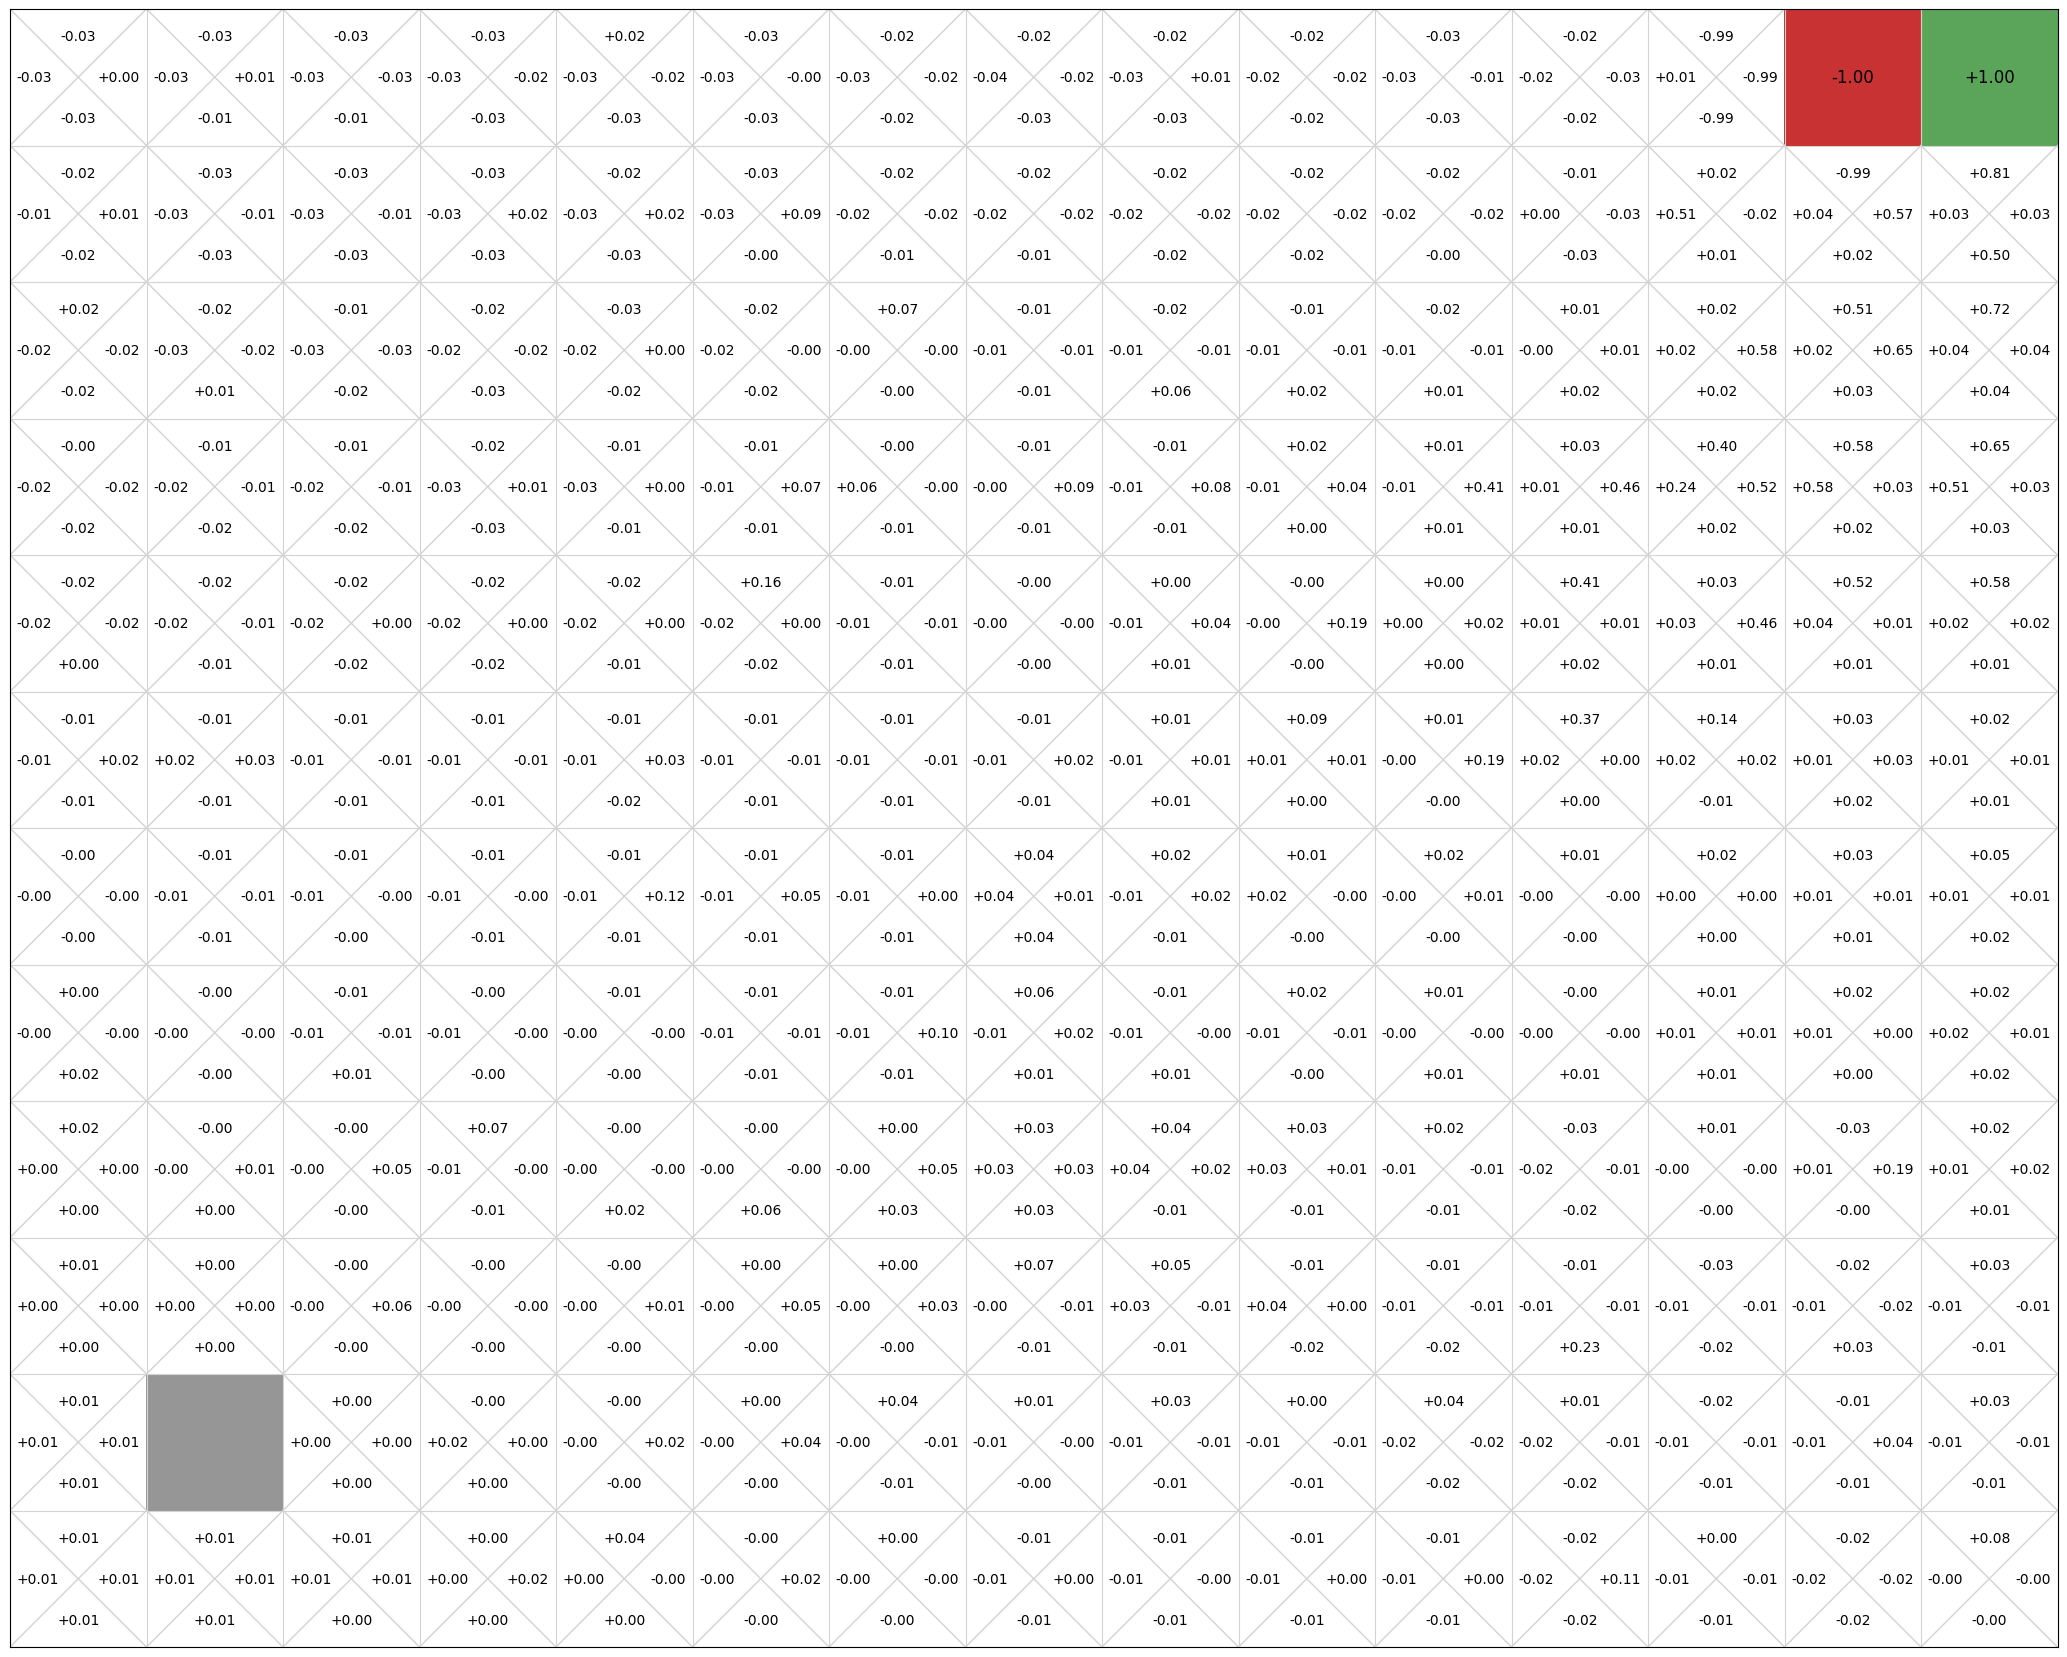

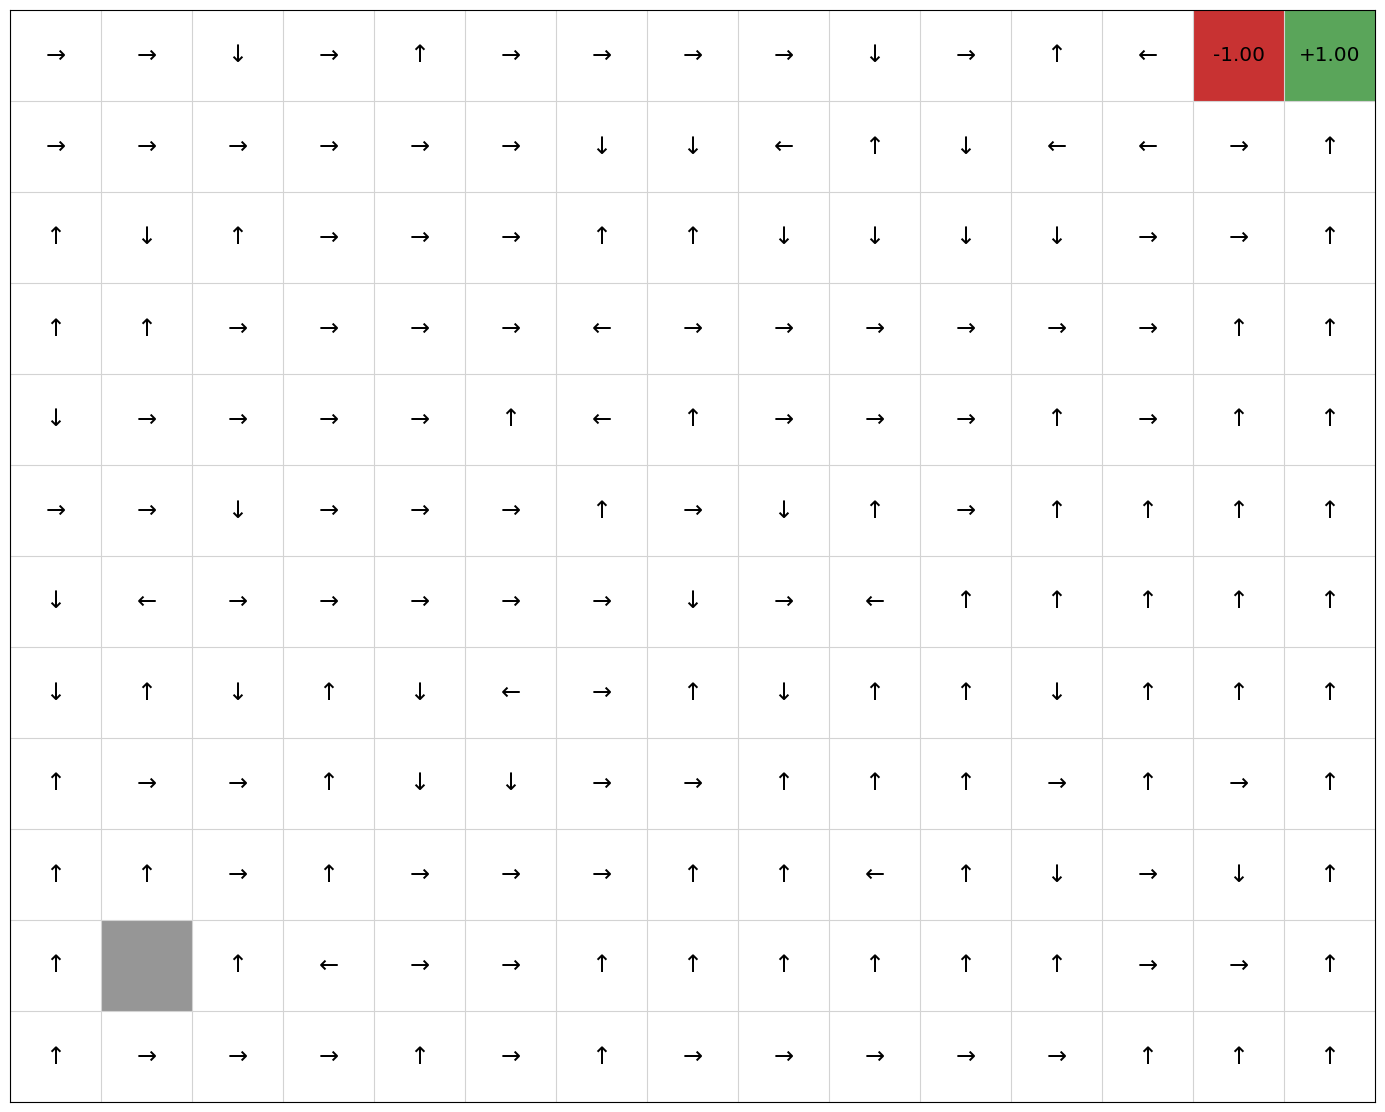

In [7]:
from qtable import QTable
from qlearning import QLearning
from reward_shaped_qlearning import RewardShapedQLearning
from gridworld_potential_function import GridWorldPotentialFunction
from q_policy import QPolicy
from multi_armed_bandit.epsilon_greedy import EpsilonGreedy


mdp = GridWorld(width = 15, height = 12, goals = [((14,11), 1), ((13,11), -1)])
qfunction = QTable()
potential = GridWorldPotentialFunction(mdp)
RewardShapedQLearning(mdp, EpsilonGreedy(), potential, qfunction).execute()
policy = QPolicy(qfunction)
mdp.visualise_q_function(qfunction)
mdp.visualise_policy(policy)
reward_shaped_rewards = mdp.get_rewards()

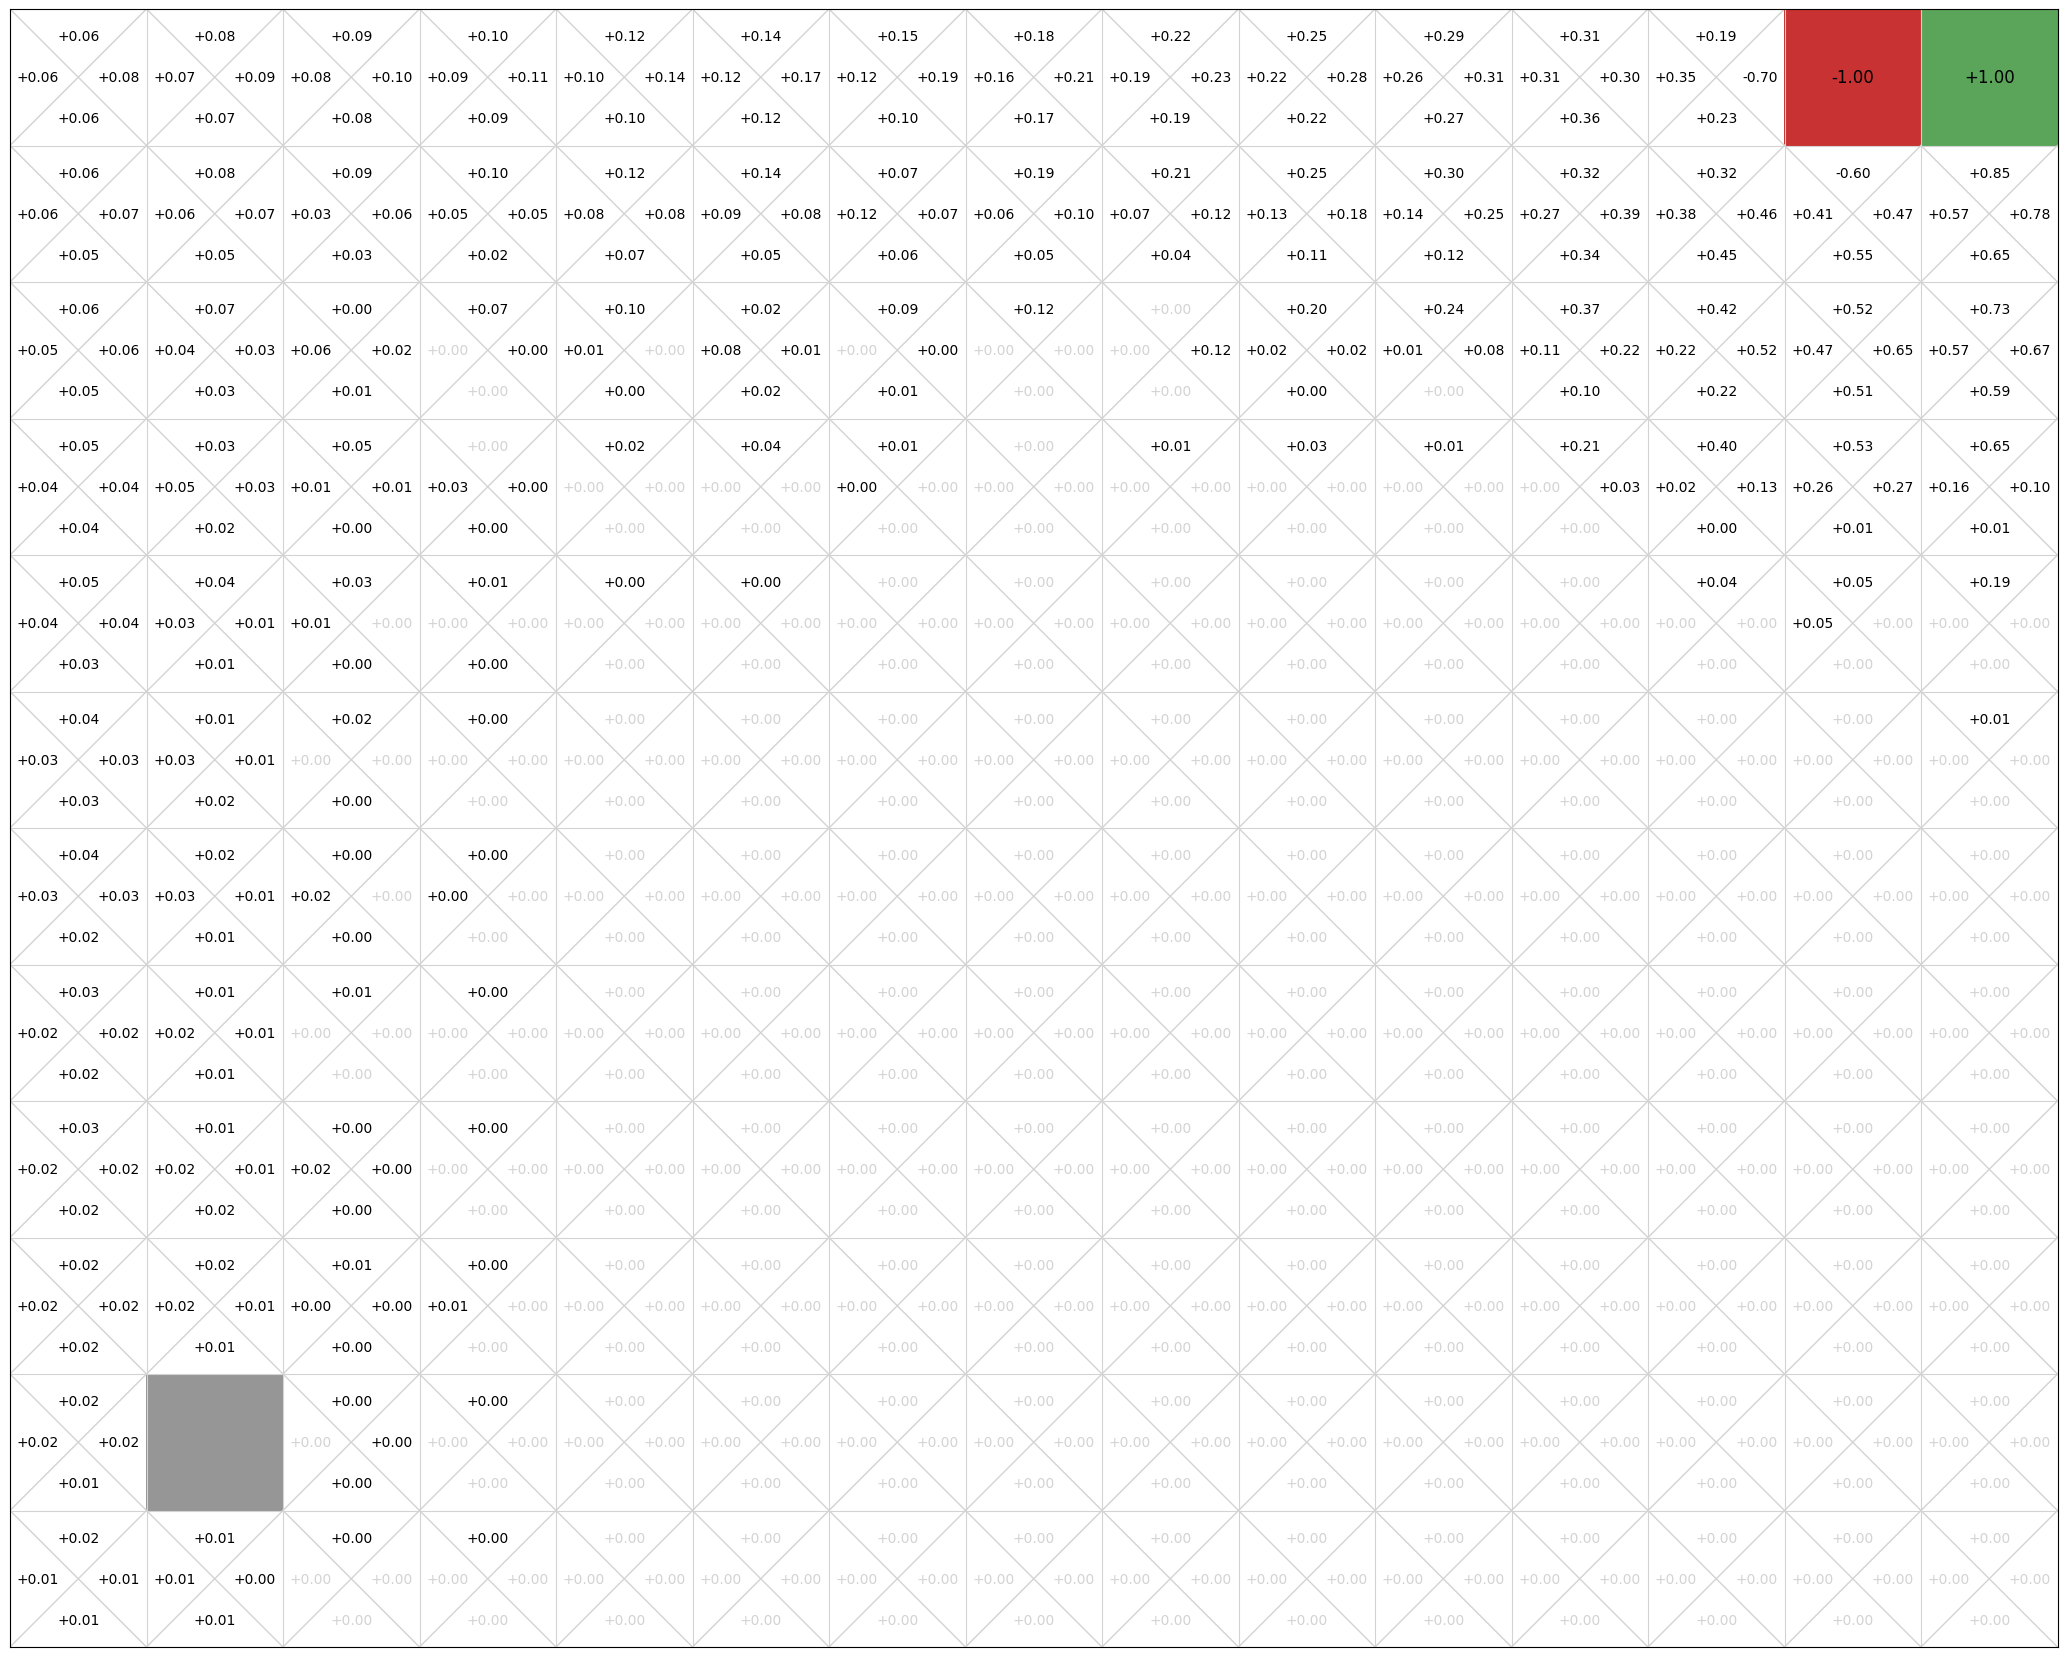

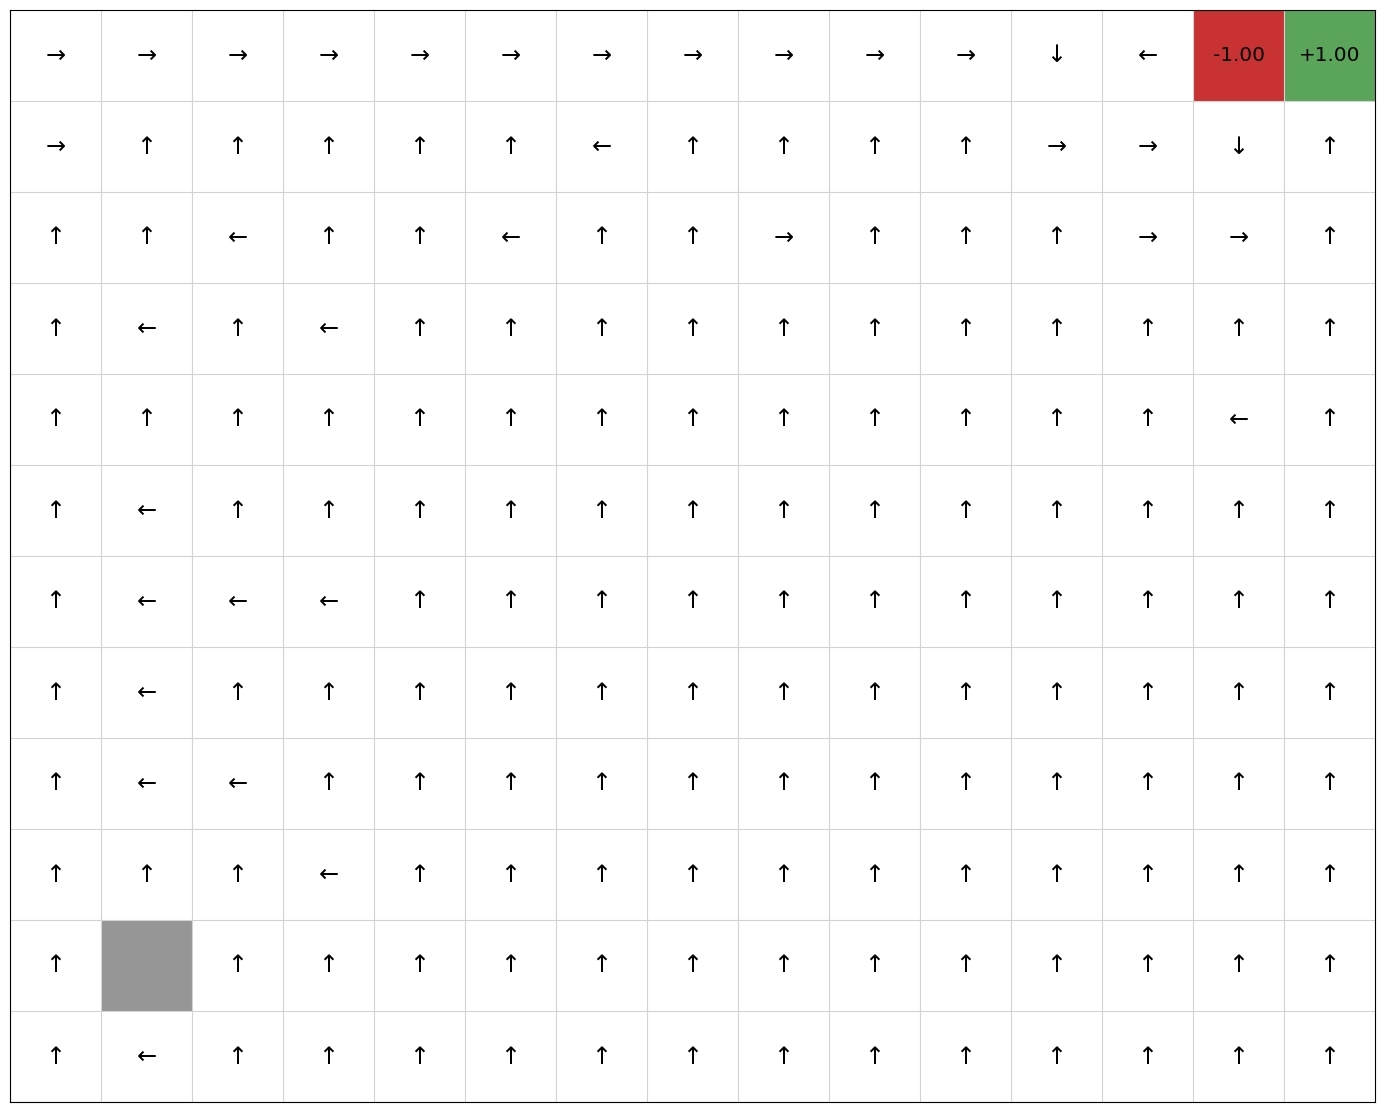

In [8]:
# Without reward shaping

mdp = GridWorld(width = 15, height = 12, goals = [((14,11), 1), ((13,11), -1)])
qfunction = QTable()
QLearning(mdp, EpsilonGreedy(), qfunction).execute()
policy = QPolicy(qfunction)
mdp.visualise_q_function(qfunction)
mdp.visualise_policy(policy)
q_learning_rewards = mdp.get_rewards()

In [12]:
from tests.plot import Plot

Plot.plot_episode_length(
    ["Tabular Q-learning", "Reward shaping"],
    [q_learning_rewards, reward_shaped_rewards],
)

ModuleNotFoundError: No module named 'tests.plot'

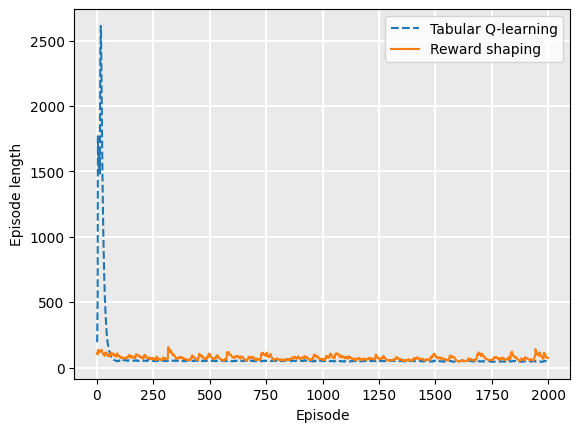

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import math


class Plot:

    # mean rewards over a window
    DEFAULT_WINDOW_SIZE = 250

    # Background colour for a plot
    BACKGROUND_COLOUR = "#EAEAEA"

    """
    Calculate the mean reward per episode over a set of episodes
    """

    def get_mean_step_rewards(runs):
        num_runs, num_episodes = len(runs), len(runs[0])
        max_num_steps = 0
        for run in runs:
            for episode in run:
                if len(episode) > max_num_steps:
                    max_num_steps = len(episode)

        mean_reward_episodes = [
            [0 for j in range(max_num_steps)] for i in range(num_episodes)
        ]

        # calculate the mean reward for each episode in each run
        for episode in range(num_episodes):
            num_steps = 0
            for run in range(num_runs):
                if len(runs[run][episode]) > num_steps:
                    num_steps = len(runs[run][episode])

            for step in range(num_steps):
                step_rewards = []
                for run in range(num_runs):
                    if step < len(runs[run][episode]):
                        step_rewards += [runs[run][episode][step]]
                mean_reward_episodes[episode][step] = np.mean(step_rewards)

        return mean_reward_episodes

    """
    Calculate the mean and stddev reward per step over all episodes of a simulation.
    """

    def get_mean_rewards_per_step_old(rewards):
        mean_rewards = []
        # calculate the mean reward for each step in an episode
        for step in range(len(rewards[0])):
            sum = 0.0
            for episode in range(len(rewards)):
                sum += rewards[episode][step]
            mean_rewards += [sum / len(rewards)]
        return mean_rewards

    def get_mean_rewards_per_step(rewards):
        mean_rewards = []
        stddev_rewards = []

        # transpose the matrix
        columns = [list(column) for column in zip(*rewards)]

        # calculate sum and variance of each column (of original matrix)
        for column in columns:
            mean = sum(column) / len(column)
            variance = sum((reward - mean) ** 2 for reward in column) / len(column)
            mean_rewards += [mean]
            stddev_rewards += [math.sqrt(variance)]
        return (mean_rewards, stddev_rewards)

    """
        Calculate the mean reward for each episode,
        averaging the last 'window_size' number of episodes
    """

    def get_mean_rewards_per_episode(rewards, window_size=DEFAULT_WINDOW_SIZE):
        summed_rewards = []

        for episode in rewards:
            summed_rewards += [sum(episode)]

        mean_rewards = []
        for i in range(len(summed_rewards)):
            window = summed_rewards[max(0, i - window_size) : i + 1]
            mean_rewards += [sum(window) / len(window)]
        return mean_rewards

    """
        Calculate the exponential moving mean of a list of rewards
    """

    def get_ema(rewards, smoothing_factor=0.9):
        smoothed_rewards = []
        for reward in rewards:
            if smoothed_rewards == []:
                smoothed_rewards = [reward]
            else:
                smoothed_rewards += [
                    smoothed_rewards[-1] * smoothing_factor
                    + reward * (1 - smoothing_factor)
                ]
        return smoothed_rewards

    """
        Calculate the length of each episode
    """

    def get_episode_length(rewards):
        episode_lengths = []

        # Omit the first episode as it is (usually) random
        for episode in rewards[1:]:
            episode_lengths += [len(episode)]

        return episode_lengths

    """
    Plot the rewards per step of several methods.
    """

    def plot_rewards(labels, reward_list, smoothing_factor=0.9):
        x = np.linspace(0, len(reward_list[0][0]), len(reward_list[0][0]))
        index = 0
        linestyles = ["--", "-", ":", "-."]
        for rewards in reward_list:
            (mean_y, stddev_y) = Plot.get_mean_rewards_per_step(rewards)
            mean_smoothed = Plot.get_ema(mean_y, smoothing_factor=smoothing_factor)
            plt.plot(
                x,
                mean_smoothed,
                label=labels[index],
                linestyle=linestyles[index % len(linestyles)],
            )

            index += 1

        plt.xlabel("Step")
        plt.ylabel("mean reward per step")
        plt.legend()
        plt.gca().set_facecolor(Plot.BACKGROUND_COLOUR)
        plt.grid(color="white", linewidth=1.5)
        plt.show()

    def plot_cumulative_rewards(
        labels, reward_list, smoothing_factor=0.95, episodes_per_evaluation=1
    ):
        x = np.linspace(0, len(reward_list[0]), len(reward_list[0]))
        index = 0
        linestyles = ["-", "--", ":", "-."]
        for rewards in reward_list:
            y_smoothed = Plot.get_ema(rewards, smoothing_factor=smoothing_factor)
            plt.plot(
                x * episodes_per_evaluation,
                y_smoothed,
                label=labels[index],
                linestyle=linestyles[index % len(linestyles)],
            )
            index += 1

        plt.xlabel("Episode")
        plt.ylabel("Cumulative reward")
        plt.legend()
        plt.gca().set_facecolor(Plot.BACKGROUND_COLOUR)
        plt.grid(color="white", linewidth=1.5)
        plt.show()

    """
    Plot the rewards per episode of several methods.
    """

    def plot_rewards_per_episode(labels, reward_list, window_size=DEFAULT_WINDOW_SIZE):
        index = 0
        linestyles = ["--", "-", ":", "-."]
        for rewards in reward_list:
            y = Plot.get_mean_rewards_per_episode(rewards, window_size=window_size)
            x = np.linspace(0, len(y), len(y))
            y_smoothed = y  # Plot.get_ema(y)
            plt.plot(
                x,
                y_smoothed,
                label=labels[index],
                linestyle=linestyles[index % len(linestyles)],
            )
            index += 1

        plt.xlabel("Episode")
        plt.ylabel("mean reward per episode")
        plt.legend()
        plt.gca().set_facecolor(Plot.BACKGROUND_COLOUR)
        plt.grid(color="white", linewidth=1.5)
        plt.show()

    """
    Plot the rewards per episode of several runs of the same method -
    don't distinguish between lines.
    """

    def plot_multirun_rewards_per_episode(reward_list, method_label):
        index = 0
        for rewards in reward_list:
            y = Plot.get_mean_rewards_per_episode(rewards)
            x = np.linspace(0, len(y), len(y))
            y_smoothed = Plot.get_ema(y)
            plt.plot(x, y_smoothed, color="#2222aa")
            index += 1

        plt.xlabel("Episode")
        plt.ylabel("Av reward per ep - {0}".format(method_label))
        plt.gca().set_facecolor(Plot.BACKGROUND_COLOUR)
        plt.grid(color="white", linewidth=1.5)
        plt.show()

    """
    Plot the mean length of episode.
    """

    def plot_episode_length(labels, reward_list):
        index = 0
        linestyles = ["--", "-", ":", "-."]
        for rewards in reward_list:
            y = Plot.get_episode_length(rewards)
            x = np.linspace(0, len(y), len(y))
            y_smoothed = Plot.get_ema(y)
            plt.plot(
                x,
                y_smoothed,
                label=labels[index],
                linestyle=linestyles[index % len(linestyles)],
            )
            index += 1

        plt.xlabel("Episode")
        plt.ylabel("Episode length")
        plt.legend()
        plt.gca().set_facecolor(Plot.BACKGROUND_COLOUR)
        plt.grid(color="white", linewidth=1.5)
        plt.show()


Plot.plot_episode_length(
    ["Tabular Q-learning", "Reward shaping"],
    [q_learning_rewards, reward_shaped_rewards],
)